<!-- dom:TITLE: Data Analysis and Machine Learning: Logistic Regression -->
# Data Analysis and Machine Learning: Logistic Regression
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Oct 26, 2021**

Copyright 1999-2021, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license







## Plans for week 38

* Thursday: Summary of regression methods and discussion of project 1.  Start Logistic Regression

* [Video of Lecture September 23](https://www.uio.no/studier/emner/matnat/fys/FYS-STK4155/h21/forelesningsvideoer/LectureSeptember23.mp4?vrtx=view-as-webpage)

* Friday: Logistic Regression and Optimization methods

* [Video of Lecture September 24](https://www.uio.no/studier/emner/matnat/fys/FYS-STK3155/h21/forelesningsvideoer/LectureSeptember24.mp4?vrtx=view-as-webpage)

## Thursday September 23


## Ridge and LASSO Regression, reminder

The expression for the standard Mean Squared Error (MSE) which we used to define our cost function and the equations for the ordinary least squares (OLS) method, that is 
our optimization problem is

$$
{\displaystyle \min_{\boldsymbol{\beta}\in {\mathbb{R}}^{p}}}\frac{1}{n}\left\{\left(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\right)^T\left(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\right)\right\}.
$$

or we can state it as

$$
{\displaystyle \min_{\boldsymbol{\beta}\in
{\mathbb{R}}^{p}}}\frac{1}{n}\sum_{i=0}^{n-1}\left(y_i-\tilde{y}_i\right)^2=\frac{1}{n}\vert\vert \boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\vert\vert_2^2,
$$

where we have used the definition of  a norm-2 vector, that is

$$
\vert\vert \boldsymbol{x}\vert\vert_2 = \sqrt{\sum_i x_i^2}.
$$

By minimizing the above equation with respect to the parameters
$\boldsymbol{\beta}$ we could then obtain an analytical expression for the
parameters $\boldsymbol{\beta}$.  We can add a regularization parameter $\lambda$ by
defining a new cost function to be optimized, that is

$$
{\displaystyle \min_{\boldsymbol{\beta}\in
{\mathbb{R}}^{p}}}\frac{1}{n}\vert\vert \boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\vert\vert_2^2+\lambda\vert\vert \boldsymbol{\beta}\vert\vert_2^2
$$

which leads to the Ridge regression minimization problem where we
require that $\vert\vert \boldsymbol{\beta}\vert\vert_2^2\le t$, where $t$ is
a finite number larger than zero. By defining

$$
C(\boldsymbol{X},\boldsymbol{\beta})=\frac{1}{n}\vert\vert \boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\vert\vert_2^2+\lambda\vert\vert \boldsymbol{\beta}\vert\vert_1,
$$

we have a new optimization equation

$$
{\displaystyle \min_{\boldsymbol{\beta}\in
{\mathbb{R}}^{p}}}\frac{1}{n}\vert\vert \boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\vert\vert_2^2+\lambda\vert\vert \boldsymbol{\beta}\vert\vert_1
$$

which leads to Lasso regression. Lasso stands for least absolute shrinkage and selection operator. 

Here we have defined the norm-1 as

$$
\vert\vert \boldsymbol{x}\vert\vert_1 = \sum_i \vert x_i\vert.
$$

<!-- !split  -->
## Various steps in cross-validation

When the repetitive splitting of the data set is done randomly,
samples may accidently end up in a fast majority of the splits in
either training or test set. Such samples may have an unbalanced
influence on either model building or prediction evaluation. To avoid
this $k$-fold cross-validation structures the data splitting. The
samples are divided into $k$ more or less equally sized exhaustive and
mutually exclusive subsets. In turn (at each split) one of these
subsets plays the role of the test set while the union of the
remaining subsets constitutes the training set. Such a splitting
warrants a balanced representation of each sample in both training and
test set over the splits. Still the division into the $k$ subsets
involves a degree of randomness. This may be fully excluded when
choosing $k=n$. This particular case is referred to as leave-one-out
cross-validation (LOOCV). 

<!-- !split  -->
## How to set up the cross-validation for Ridge and/or Lasso

* Define a range of interest for the penalty parameter.

* Divide the data set into training and test set comprising samples $\{1, \ldots, n\} \setminus i$ and $\{ i \}$, respectively.

* Fit the linear regression model by means of ridge estimation  for each $\lambda$ in the grid using the training set, and the corresponding estimate of the error variance $\boldsymbol{\sigma}_{-i}^2(\lambda)$, as

$$
\begin{align*}
\boldsymbol{\beta}_{-i}(\lambda) & =  ( \boldsymbol{X}_{-i, \ast}^{T}
\boldsymbol{X}_{-i, \ast} + \lambda \boldsymbol{I}_{pp})^{-1}
\boldsymbol{X}_{-i, \ast}^{T} \boldsymbol{y}_{-i}
\end{align*}
$$

* Evaluate the prediction performance of these models on the test set by $C[y_i, \boldsymbol{X}_{i, \ast}; \boldsymbol{\beta}_{-i}(\lambda), \boldsymbol{\sigma}_{-i}^2(\lambda)]$. Or, by the prediction error $|y_i - \boldsymbol{X}_{i, \ast} \boldsymbol{\beta}_{-i}(\lambda)|$, the relative error, the error squared or the R2 score function.

* Repeat the first three steps  such that each sample plays the role of the test set once.

* Average the prediction performances of the test sets at each grid point of the penalty bias/parameter. It is an estimate of the prediction performance of the model corresponding to this value of the penalty parameter on novel data. 

## Cross-validation in brief

For the various values of $k$

1. shuffle the dataset randomly.

2. Split the dataset into $k$ groups.

3. For each unique group:

a. Decide which group to use as set for test data

b. Take the remaining groups as a training data set

c. Fit a model on the training set and evaluate it on the test set

d. Retain the evaluation score and discard the model


5. Summarize the model using the sample of model evaluation scores

## Code Example for Cross-validation and $k$-fold Cross-validation

The code here uses Ridge regression with cross-validation (CV)  resampling and $k$-fold CV in order to fit a specific polynomial.

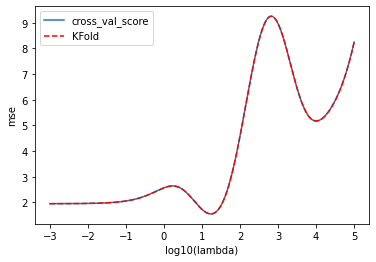

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

# Generate the data.
nsamples = 100
x = np.random.randn(nsamples)
y = 3*x**2 + np.random.randn(nsamples)

## Cross-validation on Ridge regression using KFold only

# Decide degree on polynomial to fit
poly = PolynomialFeatures(degree = 6)

# Decide which values of lambda to use
nlambdas = 500
lambdas = np.logspace(-3, 5, nlambdas)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        xtrain = x[train_inds]
        ytrain = y[train_inds]

        xtest = x[test_inds]
        ytest = y[test_inds]

        Xtrain = poly.fit_transform(xtrain[:, np.newaxis])
        ridge.fit(Xtrain, ytrain[:, np.newaxis])

        Xtest = poly.fit_transform(xtest[:, np.newaxis])
        ypred = ridge.predict(Xtest)

        scores_KFold[i,j] = np.sum((ypred - ytest[:, np.newaxis])**2)/np.size(ypred)

        j += 1
    i += 1


estimated_mse_KFold = np.mean(scores_KFold, axis = 1)

## Cross-validation using cross_val_score from sklearn along with KFold

# kfold is an instance initialized above as:
# kfold = KFold(n_splits = k)

estimated_mse_sklearn = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)

    X = poly.fit_transform(x[:, np.newaxis])
    estimated_mse_folds = cross_val_score(ridge, X, y[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)

    i += 1

## Plot and compare the slightly different ways to perform cross-validation

plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn, label = 'cross_val_score')
plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()

plt.show()

## To think about, first part

When you are comparing your own code with for example **Scikit-Learn**'s
library, there are some technicalities to keep in mind.  The examples
here demonstrate some of these aspects with potential pitfalls.

The discussion here focuses on the role of the intercept, how we can
set up the design matrix, what scaling we should use and other topics
which tend  confuse us.



The intercept can be interpreted as the expected value of our
target/output variables when all other predictors are set to zero.
Thus, if we cannot assume that the expected outputs/targets are zero
when all predictors are zero (the columns in the design matrix), it
may be a bad idea to implement a model which penalizes the intercept.
Furthermore, in for example Ridge and Lasso regression, the default solutions
from the library **Scikit-Learn** (when not shrinking $\beta_0$) for the unknown parameters
$\boldsymbol{\beta}$, are derived under the assumption that both $\boldsymbol{y}$ and
$\boldsymbol{X}$ are zero centered, that is we subtract the mean values.


## More thinking


If our predictors represent different scales, then it is important to
standardize the design matrix $\boldsymbol{X}$ by subtracting the mean of each
column from the corresponding column and dividing the column with its
standard deviation. Most machine learning libraries do this as a default. This means that if you compare your code with the results from a given library,
the results may differ. 

The
[Standadscaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
function in **Scikit-Learn** does this for us.  For the data sets we
have been studying in our various examples, the data are in many cases
already scaled and there is no need to scale them. You as a user of different machine learning algorithms, should always perform  a
survey of your data, with a critical assessment of them in case you need to scale the data.

If you need to scale the data, not doing so will give an *unfair*
penalization of the parameters since their magnitude depends on the
scale of their corresponding predictor.

Suppose as an example that you 
you have an input variable given by the heights of different persons.
Human height might be measured in inches or meters or
kilometers. If measured in kilometers, a standard linear regression
model with this predictor would probably give a much bigger
coefficient term, than if measured in millimeters.
This can clearly lead to problems in evaluating the cost/loss functions.


## Still thinking

Keep in mind that when you transform your data set before training a model, the same transformation needs to be done
on your eventual new data set  before making a prediction. If we translate this into a Python code, it would could be implemented as follows

In [2]:
#Model training, we compute the mean value of y and X
y_train_mean = np.mean(y_train)
X_train_mean = np.mean(X_train,axis=0)
X_train = X_train - X_train_mean
y_train = y_train - y_train_mean

# The we fit our model with the training data
trained_model = some_model.fit(X_train,y_train)


#Model prediction, we need also to transform our data set used for the prediction.
X_test = X_test - X_train_mean #Use mean from training data
y_pred = trained_model(X_test)
y_pred = y_pred + y_train_mean

NameError: name 'y_train' is not defined

## What does centering (subtracting the mean values) mean mathematically?


Let us try to understand what this may imply mathematically when we
subtract the mean values, also known as *zero centering*. For
simplicity, we will focus on  ordinary regression, as done in the above example.

The cost/loss function  for regression is

$$
C(\beta_0, \beta_1, ... , \beta_{p-1}) = \frac{1}{n}\sum_{i=0}^{n} \left(y_i - \beta_0 - \sum_{j=1}^{p-1} X_{ij}\beta_j\right)^2,.
$$

Recall also that we use the squared value since this leads to an increase of the penalty for higher differences between predicted and output/target values.

What we have done is to single out the $\beta_0$ term in the definition of the mean squared error (MSE).
The design matrix
$X$ does in this case not contain any intercept column.
When we take the derivative with respect to $\beta_0$, we want the derivative to obey

$$
\frac{\partial C}{\partial \beta_j} = 0,
$$

for all $j$. For $\beta_0$ we have

$$
\frac{\partial C}{\partial \beta_0} = -\frac{2}{n}\sum_{i=0}^{n-1} \left(y_i - \beta_0 - \sum_{j=1}^{p-1} X_{ij} \beta_j\right).
$$

Multiplying away the constant $2/n$, we obtain

$$
\sum_{i=0}^{n-1} \beta_0 = \sum_{i=0}^{n-1}y_i - \sum_{i=0}^{n-1} \sum_{j=1}^{p-1} X_{ij} \beta_j.
$$

## Further Manipulations


Let us special first to the case where we have only two parameters $\beta_0$ and $\beta_1$.
Our result for $\beta_0$ simplifies then to

$$
n\beta_0 = \sum_{i=0}^{n-1}y_i - \sum_{i=0}^{n-1} X_{i1} \beta_1.
$$

We obtain then

$$
\beta_0 = \frac{1}{n}\sum_{i=0}^{n-1}y_i - \beta_1\frac{1}{n}\sum_{i=0}^{n-1} X_{i1}.
$$

If we define

$$
\mu_1=\frac{1}{n}\sum_{i=0}^{n-1} (X_{i1},
$$

and if we define the mean value of the outputs as

$$
\mu_y=\frac{1}{n}\sum_{i=0}^{n-1}y_i,
$$

we have

$$
\beta_0 = \mu_y - \beta_1\mu_{1}.
$$

In the general case, that is we have more parameters than $\beta_0$ and $\beta_1$, we have

$$
\beta_0 = \frac{1}{n}\sum_{i=0}^{n-1}y_i - \frac{1}{n}\sum_{i=0}^{n-1}\sum_{j=1}^{p-1} X_{ij}\beta_j.
$$

Replacing $y_i$ with $y_i - y_i - \overline{\boldsymbol{y}}$ and centering also our design matrix results in a cost function (in vector-matrix disguise)

$$
C(\boldsymbol{\beta}) = (\boldsymbol{\tilde{y}} - \tilde{X}\boldsymbol{\beta})^T(\boldsymbol{\tilde{y}} - \tilde{X}\boldsymbol{\beta}).
$$

## Wrapping it up

If we minimize with respect to $\boldsymbol{\beta}$ we have then

$$
\hat{\boldsymbol{\beta}} = (\tilde{X}^T\tilde{X})^{-1}\tilde{X}^T\boldsymbol{\tilde{y}},
$$

where $\boldsymbol{\tilde{y}} = \boldsymbol{y} - \overline{\boldsymbol{y}}$
and $\tilde{X}_{ij} = X_{ij} - \frac{1}{n}\sum_{k=0}^{n-1}X_{kj}$.

For Ridge regression we need to add $\lambda \boldsymbol{\beta}^T\boldsymbol{\beta}$ to the cost function and get then

$$
\hat{\boldsymbol{\beta}} = (\tilde{X}^T\tilde{X} + \lambda I)^{-1}\tilde{X}^T\boldsymbol{\tilde{y}}.
$$

What does this mean? And why do we insist on all this? Let us look at some examples.



## Linear Regression code, Intercept handling first

This code shows a simple first-order fit to a data set using the above transformed data, where we consider the role of the intercept first, by either excluding it or including it (*code example thanks to  Øyvind Sigmundson Schøyen*). Here our scaling of the data is done by subtracting the mean values only.
Note also that we do not split the data into training and test.

True beta: [2, 0.5, 3.7]
Fitted beta: [2.08376632 0.19569961 3.97898392]
Sklearn fitted beta: [2.08376632 0.19569961 3.97898392]
MSE with intercept column
0.004113634617443131
MSE with intercept column from SKL
0.0041136346174431284
Manual intercept: 2.083766322923905
Fitted beta (wiothout intercept): [0.19569961 3.97898392]
Sklearn intercept: 2.0837663229239025
Sklearn fitted beta (without intercept): [0.19569961 3.97898392]
MSE with Manual intercept
0.004113634617443137
MSE with Sklearn intercept
0.004113634617443135


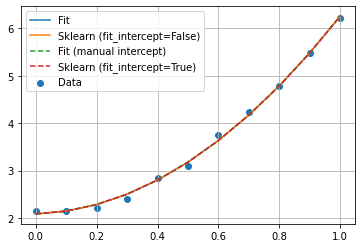

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression


np.random.seed(2021)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n


def fit_beta(X, y):
    return np.linalg.pinv(X.T @ X) @ X.T @ y


true_beta = [2, 0.5, 3.7]

x = np.linspace(0, 1, 11)
y = np.sum(
    np.asarray([x ** p * b for p, b in enumerate(true_beta)]), axis=0
) + 0.1 * np.random.normal(size=len(x))

degree = 3
X = np.zeros((len(x), degree))

# Include the intercept in the design matrix
for p in range(degree):
    X[:, p] = x ** p

beta = fit_beta(X, y)

# Intercept is included in the design matrix
skl = LinearRegression(fit_intercept=False).fit(X, y)

print(f"True beta: {true_beta}")
print(f"Fitted beta: {beta}")
print(f"Sklearn fitted beta: {skl.coef_}")
ypredictOwn = X @ beta
ypredictSKL = skl.predict(X)
print(f"MSE with intercept column")
print(MSE(y,ypredictOwn))
print(f"MSE with intercept column from SKL")
print(MSE(y,ypredictSKL))


plt.figure()
plt.scatter(x, y, label="Data")
plt.plot(x, X @ beta, label="Fit")
plt.plot(x, skl.predict(X), label="Sklearn (fit_intercept=False)")


# Do not include the intercept in the design matrix
X = np.zeros((len(x), degree - 1))

for p in range(degree - 1):
    X[:, p] = x ** (p + 1)

# Intercept is not included in the design matrix
skl = LinearRegression(fit_intercept=True).fit(X, y)

# Use centered values for X and y when computing coefficients
y_offset = np.average(y, axis=0)
X_offset = np.average(X, axis=0)

beta = fit_beta(X - X_offset, y - y_offset)
intercept = np.mean(y_offset - X_offset @ beta)

print(f"Manual intercept: {intercept}")
print(f"Fitted beta (wiothout intercept): {beta}")
print(f"Sklearn intercept: {skl.intercept_}")
print(f"Sklearn fitted beta (without intercept): {skl.coef_}")
ypredictOwn = X @ beta
ypredictSKL = skl.predict(X)
print(f"MSE with Manual intercept")
print(MSE(y,ypredictOwn+intercept))
print(f"MSE with Sklearn intercept")
print(MSE(y,ypredictSKL))

plt.plot(x, X @ beta + intercept, "--", label="Fit (manual intercept)")
plt.plot(x, skl.predict(X), "--", label="Sklearn (fit_intercept=True)")
plt.grid()
plt.legend()

plt.show()

The intercept is the value of our output/target variable
when all our features are zero and our function crosses the $y$-axis (for a one-dimensional case). 

Printing the MSE, we see first that both methods give the same MSE, as
they should.  However, when we move to for example Ridge regression,
the way we treat the intercept may give a larger or smaller MSE,
meaning that the MSE can be penalized by the value of the
intercept. Not including the intercept in the fit, means that the
regularization term does not include $\beta_0$. For different values
of $\lambda$, this may lead to differeing MSE values. 

To remind the reader, the regularization term, with the intercept in Ridge regression is given by

$$
\lambda \vert\vert \boldsymbol{\beta} \vert\vert_2^2 = \lambda \sum_{j=0}^{p-1}\beta_j^2,
$$

but when we take out the intercept, this equation becomes

$$
\lambda \vert\vert \boldsymbol{\beta} \vert\vert_2^2 = \lambda \sum_{j=1}^{p-1}\beta_j^2.
$$

For Lasso regression we have

$$
\lambda \vert\vert \boldsymbol{\beta} \vert\vert_1 = \lambda \sum_{j=1}^{p-1}\vert\beta_j\vert.
$$

It means that, when scaling the design matrix and the outputs/targets, by subtracting the mean values, we have an optimization problem which is not penalized by the intercept. The MSE value can then be smaller since it focuses only on the remaining quantities. If we however bring back the intercept, we will get a MSE which then contains the intercept. 

## Code Examples

Armed with this wisdom, we attempt first to simply set the intercept equal to **False** in our implementation of Ridge regression for our well-known  vanilla data set.

Beta values for own Ridge implementation
[ 1.03032441e+00  6.28336218e-02 -6.24175744e-01  5.21169160e-02
  2.80847477e-01  2.12552073e-01  8.13220609e-02 -1.69634577e-02
 -6.50846112e-02 -7.38962193e-02 -5.94226022e-02 -3.50227564e-02
 -9.80609616e-03  1.08299273e-02  2.41882037e-02  2.93492130e-02
  2.64742912e-02  1.63249532e-02 -5.01831271e-05 -2.15098090e-02]
Beta values for Scikit-Learn Ridge implementation
[ 1.03032441e+00  6.28336218e-02 -6.24175744e-01  5.21169159e-02
  2.80847477e-01  2.12552073e-01  8.13220609e-02 -1.69634577e-02
 -6.50846112e-02 -7.38962192e-02 -5.94226022e-02 -3.50227564e-02
 -9.80609616e-03  1.08299273e-02  2.41882037e-02  2.93492130e-02
  2.64742912e-02  1.63249532e-02 -5.01831188e-05 -2.15098090e-02]
MSE values for own Ridge implementation
4.3632959224230663e-07
MSE values for Scikit-Learn Ridge implementation
4.3632959170578395e-07
Beta values for own Ridge implementation
[ 1.03630548 -0.01963611 -0.37900111 -0.07062318  0.12182967  0.16343471
  0.1300

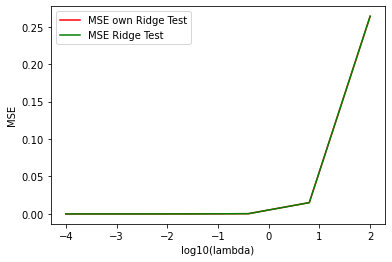

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n


# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)

Maxpolydegree = 20
X = np.zeros((n,Maxpolydegree))
#We include explicitely the intercept column
for degree in range(Maxpolydegree):
    X[:,degree] = x**degree
# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

p = Maxpolydegree
I = np.eye(p,p)
# Decide which values of lambda to use
nlambdas = 6
MSEOwnRidgePredict = np.zeros(nlambdas)
MSERidgePredict = np.zeros(nlambdas)
lambdas = np.logspace(-4, 2, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]
    OwnRidgeBeta = np.linalg.pinv(X_train.T @ X_train+lmb*I) @ X_train.T @ y_train
    # Note: we include the intercept column and no scaling
    RegRidge = linear_model.Ridge(lmb,fit_intercept=False)
    RegRidge.fit(X_train,y_train)
    # and then make the prediction
    ytildeOwnRidge = X_train @ OwnRidgeBeta
    ypredictOwnRidge = X_test @ OwnRidgeBeta
    ytildeRidge = RegRidge.predict(X_train)
    ypredictRidge = RegRidge.predict(X_test)
    MSEOwnRidgePredict[i] = MSE(y_test,ypredictOwnRidge)
    MSERidgePredict[i] = MSE(y_test,ypredictRidge)
    print("Beta values for own Ridge implementation")
    print(OwnRidgeBeta)
    print("Beta values for Scikit-Learn Ridge implementation")
    print(RegRidge.coef_)
    print("MSE values for own Ridge implementation")
    print(MSEOwnRidgePredict[i])
    print("MSE values for Scikit-Learn Ridge implementation")
    print(MSERidgePredict[i])

# Now plot the results
plt.figure()
plt.plot(np.log10(lambdas), MSEOwnRidgePredict, 'r', label = 'MSE own Ridge Test')
plt.plot(np.log10(lambdas), MSERidgePredict, 'g', label = 'MSE Ridge Test')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

The results here agree when we force **Scikit-Learn**'s Ridge function to include the first column in our design matrix.
We see that the results agree very well. Here we have thus explicitely included the intercept column in the design matrix.
What happens if we do not include the intercept in our fit?
Let us see how we can change this code by zero centering (thanks to Stian Bilek for inpouts here).

## Taking out the mean

Beta values for own Ridge implementation
[ 3.43579948e-02 -5.43330971e-01 -3.10141413e-03  2.47116868e-01
  2.18613217e-01  1.02054837e-01 -4.25617655e-04 -5.90475506e-02
 -7.68534263e-02 -6.68929213e-02 -4.24906604e-02 -1.40927184e-02
  1.11482289e-02  2.88529063e-02  3.67047975e-02  3.38135733e-02
  2.02198702e-02 -3.46383925e-03 -3.63025821e-02]
Beta values for Scikit-Learn Ridge implementation
[ 3.43579948e-02 -5.43330971e-01 -3.10141413e-03  2.47116868e-01
  2.18613217e-01  1.02054837e-01 -4.25617648e-04 -5.90475506e-02
 -7.68534263e-02 -6.68929213e-02 -4.24906604e-02 -1.40927184e-02
  1.11482289e-02  2.88529063e-02  3.67047975e-02  3.38135733e-02
  2.02198702e-02 -3.46383925e-03 -3.63025821e-02]
Intercept from own implementation:
1.0330308045187284
Intercept from Scikit-Learn Ridge implementation
1.0330308045183763
MSE values for own Ridge implementation
3.1392559589438813e-06
MSE values for Scikit-Learn Ridge implementation
3.1392559585649594e-06
Beta values for own Ridge implem

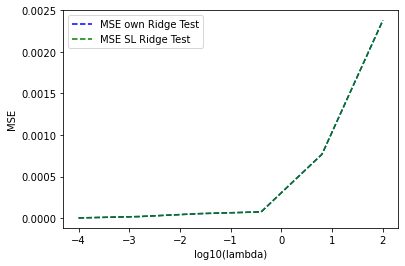

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(315)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)

Maxpolydegree = 20
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#For our own implementation, we will need to deal with the intercept by centering the design matrix and the target variable
X_train_mean = np.mean(X_train,axis=0)
#Center by removing mean from each feature
X_train_scaled = X_train - X_train_mean 
X_test_scaled = X_test - X_train_mean
#The model intercept (called y_scaler) is given by the mean of the target variable (IF X is centered)
#Remove the intercept from the training data.
y_scaler = np.mean(y_train)           
y_train_scaled = y_train - y_scaler   

p = Maxpolydegree-1
I = np.eye(p,p)
# Decide which values of lambda to use
nlambdas = 6
MSEOwnRidgePredict = np.zeros(nlambdas)
MSERidgePredict = np.zeros(nlambdas)

lambdas = np.logspace(-4, 2, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]
    OwnRidgeBeta = np.linalg.pinv(X_train_scaled.T @ X_train_scaled+lmb*I) @ X_train_scaled.T @ (y_train_scaled)
    intercept_ = y_scaler - X_train_mean@OwnRidgeBeta #The intercept can be shifted so the model can predict on uncentered data
    #Add intercept to prediction
    ypredictOwnRidge = X_test_scaled @ OwnRidgeBeta + y_scaler 
    RegRidge = linear_model.Ridge(lmb)
    RegRidge.fit(X_train,y_train)
    ypredictRidge = RegRidge.predict(X_test)
    MSEOwnRidgePredict[i] = MSE(y_test,ypredictOwnRidge)
    MSERidgePredict[i] = MSE(y_test,ypredictRidge)
    print("Beta values for own Ridge implementation")
    print(OwnRidgeBeta) #Intercept is given by mean of target variable
    print("Beta values for Scikit-Learn Ridge implementation")
    print(RegRidge.coef_)
    print('Intercept from own implementation:')
    print(intercept_)
    print('Intercept from Scikit-Learn Ridge implementation')
    print(RegRidge.intercept_)
    print("MSE values for own Ridge implementation")
    print(MSEOwnRidgePredict[i])
    print("MSE values for Scikit-Learn Ridge implementation")
    print(MSERidgePredict[i])


# Now plot the results
plt.figure()
plt.plot(np.log10(lambdas), MSEOwnRidgePredict, 'b--', label = 'MSE own Ridge Test')
plt.plot(np.log10(lambdas), MSERidgePredict, 'g--', label = 'MSE SL Ridge Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

We see here, when compared to the code which includes explicitely the
intercept column, that our MSE value is actually smaller. This is
because the regularization term does not include the intercept value
$\beta_0$ in the fitting.  This applies to Lasso regularization as
well.  It means that our optimization is now done only with the
centered matrix and/or vector that enter the fitting procedure. Note
also that the problem with the intercept occurs mainly in these type
of polynomial fitting problem.

The next example is indeed an example where all these discussions about the role of intercept are not present.


## More complicated Example: The Ising model

The one-dimensional Ising model with nearest neighbor interaction, no
external field and a constant coupling constant $J$ is given by

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
    H = -J \sum_{k}^L s_k s_{k + 1},
\label{_auto1} \tag{1}
\end{equation}
$$

where $s_i \in \{-1, 1\}$ and $s_{N + 1} = s_1$. The number of spins
in the system is determined by $L$. For the one-dimensional system
there is no phase transition.

We will look at a system of $L = 40$ spins with a coupling constant of
$J = 1$. To get enough training data we will generate 10000 states
with their respective energies.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.linalg as scl
from sklearn.model_selection import train_test_split
import tqdm
sns.set(color_codes=True)
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

L = 40
n = int(1e4)

spins = np.random.choice([-1, 1], size=(n, L))
J = 1.0

energies = np.zeros(n)

for i in range(n):
    energies[i] = - J * np.dot(spins[i], np.roll(spins[i], 1))

Here we use ordinary least squares
regression to predict the energy for the nearest neighbor
one-dimensional Ising model on a ring, i.e., the endpoints wrap
around. We will use linear regression to fit a value for
the coupling constant to achieve this.

## Reformulating the problem to suit regression

A more general form for the one-dimensional Ising model is

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
    H = - \sum_j^L \sum_k^L s_j s_k J_{jk}.
\label{_auto2} \tag{2}
\end{equation}
$$

Here we allow for interactions beyond the nearest neighbors and a state dependent
coupling constant. This latter expression can be formulated as
a matrix-product

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
    \boldsymbol{H} = \boldsymbol{X} J,
\label{_auto3} \tag{3}
\end{equation}
$$

where $X_{jk} = s_j s_k$ and $J$ is a matrix which consists of the
elements $-J_{jk}$. This form of writing the energy fits perfectly
with the form utilized in linear regression, that is

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
    \boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{\epsilon},
\label{_auto4} \tag{4}
\end{equation}
$$

We split the data in training and test data as discussed in the previous example

In [ ]:
X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Linear regression

In the ordinary least squares method we choose the cost function

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
    C(\boldsymbol{X}, \boldsymbol{\beta})= \frac{1}{n}\left\{(\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y})^T(\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y})\right\}.
\label{_auto5} \tag{5}
\end{equation}
$$

We then find the extremal point of $C$ by taking the derivative with respect to $\boldsymbol{\beta}$ as discussed above.
This yields the expression for $\boldsymbol{\beta}$ to be

$$
\boldsymbol{\beta} = \frac{\boldsymbol{X}^T \boldsymbol{y}}{\boldsymbol{X}^T \boldsymbol{X}},
$$

which immediately imposes some requirements on $\boldsymbol{X}$ as there must exist
an inverse of $\boldsymbol{X}^T \boldsymbol{X}$. If the expression we are modeling contains an
intercept, i.e., a constant term, we must make sure that the
first column of $\boldsymbol{X}$ consists of $1$. We do this here

In [ ]:
X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)
X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

In [ ]:
def ols_inv(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return scl.inv(x.T @ x) @ (x.T @ y)
beta = ols_inv(X_train_own, y_train)

## Singular Value decomposition

Doing the inversion directly turns out to be a bad idea since the matrix
$\boldsymbol{X}^T\boldsymbol{X}$ is singular. An alternative approach is to use the **singular
value decomposition**. Using the definition of the Moore-Penrose
pseudoinverse we can write the equation for $\boldsymbol{\beta}$ as

$$
\boldsymbol{\beta} = \boldsymbol{X}^{+}\boldsymbol{y},
$$

where the pseudoinverse of $\boldsymbol{X}$ is given by

$$
\boldsymbol{X}^{+} = \frac{\boldsymbol{X}^T}{\boldsymbol{X}^T\boldsymbol{X}}.
$$

Using singular value decomposition we can decompose the matrix  $\boldsymbol{X} = \boldsymbol{U}\boldsymbol{\Sigma} \boldsymbol{V}^T$,
where $\boldsymbol{U}$ and $\boldsymbol{V}$ are orthogonal(unitary) matrices and $\boldsymbol{\Sigma}$ contains the singular values (more details below).
where $X^{+} = V\Sigma^{+} U^T$. This reduces the equation for
$\omega$ to

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
    \boldsymbol{\beta} = \boldsymbol{V}\boldsymbol{\Sigma}^{+} \boldsymbol{U}^T \boldsymbol{y}.
\label{_auto6} \tag{6}
\end{equation}
$$

Note that solving this equation by actually doing the pseudoinverse
(which is what we will do) is not a good idea as this operation scales
as $\mathcal{O}(n^3)$, where $n$ is the number of elements in a
general matrix. Instead, doing $QR$-factorization and solving the
linear system as an equation would reduce this down to
$\mathcal{O}(n^2)$ operations.

In [ ]:
def ols_svd(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    u, s, v = scl.svd(x)
    return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ y

In [ ]:
beta = ols_svd(X_train_own,y_train)

When extracting the $J$-matrix  we need to make sure that we remove the intercept, as is done here

In [ ]:
J = beta[1:].reshape(L, L)

A way of looking at the coefficients in $J$ is to plot the matrices as images.

In [ ]:
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J, **cmap_args)
plt.title("OLS", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

It is interesting to note that OLS
considers both $J_{j, j + 1} = -0.5$ and $J_{j, j - 1} = -0.5$ as
valid matrix elements for $J$.
In our discussion below on hyperparameters and Ridge and Lasso regression we will see that
this problem can be removed, partly and only with Lasso regression. 

In this case our matrix inversion was actually possible. The obvious question now is what is the mathematics behind the SVD?





## The one-dimensional Ising model

Let us bring back the Ising model again, but now with an additional
focus on Ridge and Lasso regression as well. We repeat some of the
basic parts of the Ising model and the setup of the training and test
data.  The one-dimensional Ising model with nearest neighbor
interaction, no external field and a constant coupling constant $J$ is
given by

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}
    H = -J \sum_{k}^L s_k s_{k + 1},
\label{_auto7} \tag{7}
\end{equation}
$$

where $s_i \in \{-1, 1\}$ and $s_{N + 1} = s_1$. The number of spins in the system is determined by $L$. For the one-dimensional system there is no phase transition.

We will look at a system of $L = 40$ spins with a coupling constant of $J = 1$. To get enough training data we will generate 10000 states with their respective energies.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.linalg as scl
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
import tqdm
sns.set(color_codes=True)
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

L = 40
n = int(1e4)

spins = np.random.choice([-1, 1], size=(n, L))
J = 1.0

energies = np.zeros(n)

for i in range(n):
    energies[i] = - J * np.dot(spins[i], np.roll(spins[i], 1))

A more general form for the one-dimensional Ising model is

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation}
    H = - \sum_j^L \sum_k^L s_j s_k J_{jk}.
\label{_auto8} \tag{8}
\end{equation}
$$

Here we allow for interactions beyond the nearest neighbors and a more
adaptive coupling matrix. This latter expression can be formulated as
a matrix-product on the form

<!-- Equation labels as ordinary links -->
<div id="_auto9"></div>

$$
\begin{equation}
    H = X J,
\label{_auto9} \tag{9}
\end{equation}
$$

where $X_{jk} = s_j s_k$ and $J$ is the matrix consisting of the
elements $-J_{jk}$. This form of writing the energy fits perfectly
with the form utilized in linear regression, viz.

<!-- Equation labels as ordinary links -->
<div id="_auto10"></div>

$$
\begin{equation}
    \boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}.
\label{_auto10} \tag{10}
\end{equation}
$$

We organize the data as we did above

In [ ]:
X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.96)

X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)

X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

We will do all fitting with **Scikit-Learn**,

In [ ]:
clf = skl.LinearRegression().fit(X_train, y_train)

When  extracting the $J$-matrix we make sure to remove the intercept

In [ ]:
J_sk = clf.coef_.reshape(L, L)

And then we plot the results

In [ ]:
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_sk, **cmap_args)
plt.title("LinearRegression from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

The results perfectly with our previous discussion where we used our own code.

## Ridge regression

Having explored the ordinary least squares we move on to ridge
regression. In ridge regression we include a **regularizer**. This
involves a new cost function which leads to a new estimate for the
weights $\boldsymbol{\beta}$. This results in a penalized regression problem. The
cost function is given by

3
7
 
<
<
<
!
!
M
A
T
H
_
B
L
O
C
K

In [ ]:
_lambda = 0.1
clf_ridge = skl.Ridge(alpha=_lambda).fit(X_train, y_train)
J_ridge_sk = clf_ridge.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_ridge_sk, **cmap_args)
plt.title("Ridge from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

## LASSO regression

In the **Least Absolute Shrinkage and Selection Operator** (LASSO)-method we get a third cost function.

<!-- Equation labels as ordinary links -->
<div id="_auto12"></div>

$$
\begin{equation}
    C(\boldsymbol{X}, \boldsymbol{\beta}; \lambda) = (\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y})^T(\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y}) + \lambda \sqrt{\boldsymbol{\beta}^T\boldsymbol{\beta}}.
\label{_auto12} \tag{12}
\end{equation}
$$

Finding the extremal point of this cost function is not so straight-forward as in least squares and ridge. We will therefore rely solely on the function ``Lasso`` from **Scikit-Learn**.

In [ ]:
clf_lasso = skl.Lasso(alpha=_lambda).fit(X_train, y_train)
J_lasso_sk = clf_lasso.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_lasso_sk, **cmap_args)
plt.title("Lasso from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

It is quite striking how LASSO breaks the symmetry of the coupling
constant as opposed to ridge and OLS. We get a sparse solution with
$J_{j, j + 1} = -1$.



## Performance as  function of the regularization parameter

We see how the different models perform for a different set of values for $\lambda$.

In [ ]:
lambdas = np.logspace(-4, 5, 10)

train_errors = {
    "ols_sk": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

test_errors = {
    "ols_sk": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

plot_counter = 1

fig = plt.figure(figsize=(32, 54))

for i, _lambda in enumerate(tqdm.tqdm(lambdas)):
    for key, method in zip(
        ["ols_sk", "ridge_sk", "lasso_sk"],
        [skl.LinearRegression(), skl.Ridge(alpha=_lambda), skl.Lasso(alpha=_lambda)]
    ):
        method = method.fit(X_train, y_train)

        train_errors[key][i] = method.score(X_train, y_train)
        test_errors[key][i] = method.score(X_test, y_test)

        omega = method.coef_.reshape(L, L)

        plt.subplot(10, 5, plot_counter)
        plt.imshow(omega, **cmap_args)
        plt.title(r"%s, $\lambda = %.4f$" % (key, _lambda))
        plot_counter += 1

plt.show()

We see that LASSO reaches a good solution for low
values of $\lambda$, but will "wither" when we increase $\lambda$ too
much. Ridge is more stable over a larger range of values for
$\lambda$, but eventually also fades away.

## Finding the optimal value of $\lambda$

To determine which value of $\lambda$ is best we plot the accuracy of
the models when predicting the training and the testing set. We expect
the accuracy of the training set to be quite good, but if the accuracy
of the testing set is much lower this tells us that we might be
subject to an overfit model. The ideal scenario is an accuracy on the
testing set that is close to the accuracy of the training set.

In [ ]:
fig = plt.figure(figsize=(20, 14))

colors = {
    "ols_sk": "r",
    "ridge_sk": "y",
    "lasso_sk": "c"
}

for key in train_errors:
    plt.semilogx(
        lambdas,
        train_errors[key],
        colors[key],
        label="Train {0}".format(key),
        linewidth=4.0
    )

for key in test_errors:
    plt.semilogx(
        lambdas,
        test_errors[key],
        colors[key] + "--",
        label="Test {0}".format(key),
        linewidth=4.0
    )
plt.legend(loc="best", fontsize=18)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(r"$R^2$", fontsize=18)
plt.tick_params(labelsize=18)
plt.show()

From the above figure we can see that LASSO with $\lambda = 10^{-2}$
achieves a very good accuracy on the test set. This by far surpasses the
other models for all values of $\lambda$.







<!-- !split  -->
## Logistic Regression

In linear regression our main interest was centered on learning the
coefficients of a functional fit (say a polynomial) in order to be
able to predict the response of a continuous variable on some unseen
data. The fit to the continuous variable $y_i$ is based on some
independent variables $\boldsymbol{x}_i$. Linear regression resulted in
analytical expressions for standard ordinary Least Squares or Ridge
regression (in terms of matrices to invert) for several quantities,
ranging from the variance and thereby the confidence intervals of the
parameters $\boldsymbol{\beta}$ to the mean squared error. If we can invert
the product of the design matrices, linear regression gives then a
simple recipe for fitting our data.

<!-- !split  -->
## Classification problems


Classification problems, however, are concerned with outcomes taking
the form of discrete variables (i.e. categories). We may for example,
on the basis of DNA sequencing for a number of patients, like to find
out which mutations are important for a certain disease; or based on
scans of various patients' brains, figure out if there is a tumor or
not; or given a specific physical system, we'd like to identify its
state, say whether it is an ordered or disordered system (typical
situation in solid state physics); or classify the status of a
patient, whether she/he has a stroke or not and many other similar
situations.

The most common situation we encounter when we apply logistic
regression is that of two possible outcomes, normally denoted as a
binary outcome, true or false, positive or negative, success or
failure etc.

## Optimization and Deep learning

Logistic regression will also serve as our stepping stone towards
neural network algorithms and supervised deep learning. For logistic
learning, the minimization of the cost function leads to a non-linear
equation in the parameters $\boldsymbol{\beta}$. The optimization of the
problem calls therefore for minimization algorithms. This forms the
bottle neck of all machine learning algorithms, namely how to find
reliable minima of a multi-variable function. This leads us to the
family of gradient descent methods. The latter are the working horses
of basically all modern machine learning algorithms.

We note also that many of the topics discussed here on logistic 
regression are also commonly used in modern supervised Deep Learning
models, as we will see later.


<!-- !split  -->
## Basics

We consider the case where the dependent variables, also called the
responses or the outcomes, $y_i$ are discrete and only take values
from $k=0,\dots,K-1$ (i.e. $K$ classes).

The goal is to predict the
output classes from the design matrix $\boldsymbol{X}\in\mathbb{R}^{n\times p}$
made of $n$ samples, each of which carries $p$ features or predictors. The
primary goal is to identify the classes to which new unseen samples
belong.

Let us specialize to the case of two classes only, with outputs
$y_i=0$ and $y_i=1$. Our outcomes could represent the status of a
credit card user that could default or not on her/his credit card
debt. That is

$$
y_i = \begin{bmatrix} 0 & \mathrm{no}\\  1 & \mathrm{yes} \end{bmatrix}.
$$

## Linear classifier

Before moving to the logistic model, let us try to use our linear
regression model to classify these two outcomes. We could for example
fit a linear model to the default case if $y_i > 0.5$ and the no
default case $y_i \leq 0.5$.

We would then have our 
weighted linear combination, namely

<!-- Equation labels as ordinary links -->
<div id="_auto13"></div>

$$
\begin{equation}
\boldsymbol{y} = \boldsymbol{X}^T\boldsymbol{\beta} +  \boldsymbol{\epsilon},
\label{_auto13} \tag{13}
\end{equation}
$$

where $\boldsymbol{y}$ is a vector representing the possible outcomes, $\boldsymbol{X}$ is our
$n\times p$ design matrix and $\boldsymbol{\beta}$ represents our estimators/predictors.

## Some selected properties

The main problem with our function is that it takes values on the
entire real axis. In the case of logistic regression, however, the
labels $y_i$ are discrete variables. A typical example is the credit
card data discussed below here, where we can set the state of
defaulting the debt to $y_i=1$ and not to $y_i=0$ for one the persons
in the data set (see the full example below).

One simple way to get a discrete output is to have sign
functions that map the output of a linear regressor to values $\{0,1\}$,
$f(s_i)=sign(s_i)=1$ if $s_i\ge 0$ and 0 if otherwise. 
We will encounter this model in our first demonstration of neural networks. Historically it is called the ``perceptron" model in the machine learning
literature. This model is extremely simple. However, in many cases it is more
favorable to use a ``soft" classifier that outputs
the probability of a given category. This leads us to the logistic function.

## Simple example

The following example on data for coronary heart disease (CHD) as function of age may serve as an illustration. In the code here we read and plot whether a person has had CHD (output = 1) or not (output = 0). This ouput  is plotted the person's against age. Clearly, the figure shows that attempting to make a standard linear regression fit may not be very meaningful.

,ID,Age,Agegroup,CHD
0,1,21,1,0
1,2,23,1,0
2,3,25,1,1
3,4,29,1,0
4,5,21,1,0
...,...,...,...,...
95,96,61,8,1
96,97,69,8,1
97,98,65,8,1
98,99,64,8,1


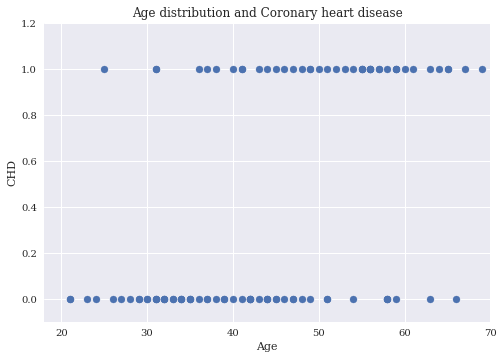

In [6]:
# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from IPython.display import display
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("chddata.csv"),'r')

# Read the chd data as  csv file and organize the data into arrays with age group, age, and chd
chd = pd.read_csv(infile, names=('ID', 'Age', 'Agegroup', 'CHD'))
chd.columns = ['ID', 'Age', 'Agegroup', 'CHD']
output = chd['CHD']
age = chd['Age']
agegroup = chd['Agegroup']
numberID  = chd['ID'] 
display(chd)

plt.scatter(age, output, marker='o')
plt.axis([18,70.0,-0.1, 1.2])
plt.xlabel(r'Age')
plt.ylabel(r'CHD')
plt.title(r'Age distribution and Coronary heart disease')
plt.show()

## Plotting the mean value for each group

What we could attempt however is to plot the mean value for each group.

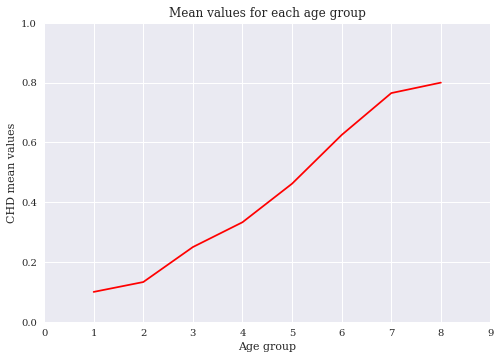

In [7]:
agegroupmean = np.array([0.1, 0.133, 0.250, 0.333, 0.462, 0.625, 0.765, 0.800])
group = np.array([1, 2, 3, 4, 5, 6, 7, 8])
plt.plot(group, agegroupmean, "r-")
plt.axis([0,9,0, 1.0])
plt.xlabel(r'Age group')
plt.ylabel(r'CHD mean values')
plt.title(r'Mean values for each age group')
plt.show()

We are now trying to find a function $f(y\vert x)$, that is a function which gives us an expected value for the output $y$ with a given input $x$.
In standard linear regression with a linear dependence on $x$, we would write this in terms of our model

$$
f(y_i\vert x_i)=\beta_0+\beta_1 x_i.
$$

This expression implies however that $f(y_i\vert x_i)$ could take any
value from minus infinity to plus infinity. If we however let
$f(y\vert y)$ be represented by the mean value, the above example
shows us that we can constrain the function to take values between
zero and one, that is we have $0 \le f(y_i\vert x_i) \le 1$. Looking
at our last curve we see also that it has an S-shaped form. This leads
us to a very popular model for the function $f$, namely the so-called
Sigmoid function or logistic model. We will consider this function as
representing the probability for finding a value of $y_i$ with a given
$x_i$.

## The logistic function

Another widely studied model, is the so-called 
perceptron model, which is an example of a "hard classification" model. We
will encounter this model when we discuss neural networks as
well. Each datapoint is deterministically assigned to a category (i.e
$y_i=0$ or $y_i=1$). In many cases, and the coronary heart disease data forms one of many such examples, it is favorable to have a "soft"
classifier that outputs the probability of a given category rather
than a single value. For example, given $x_i$, the classifier
outputs the probability of being in a category $k$.  Logistic regression
is the most common example of a so-called soft classifier. In logistic
regression, the probability that a data point $x_i$
belongs to a category $y_i=\{0,1\}$ is given by the so-called logit function (or Sigmoid) which is meant to represent the likelihood for a given event,

$$
p(t) = \frac{1}{1+\mathrm \exp{-t}}=\frac{\exp{t}}{1+\mathrm \exp{t}}.
$$

Note that $1-p(t)= p(-t)$.

## Examples of likelihood functions used in logistic regression and nueral networks


The following code plots the logistic function, the step function and other functions we will encounter from here and on.

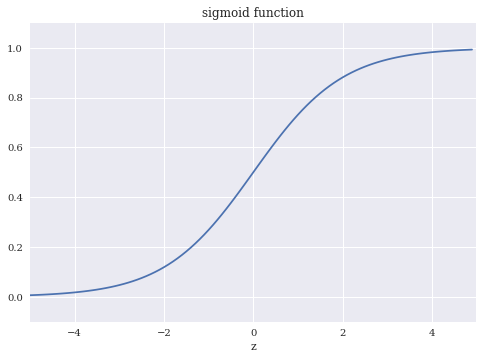

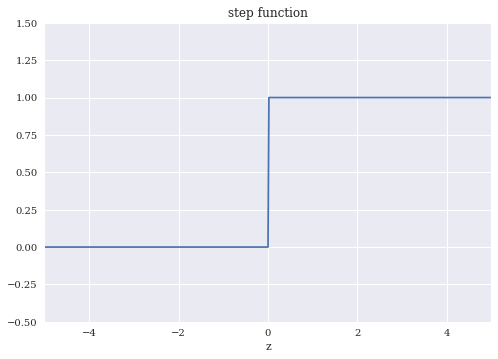

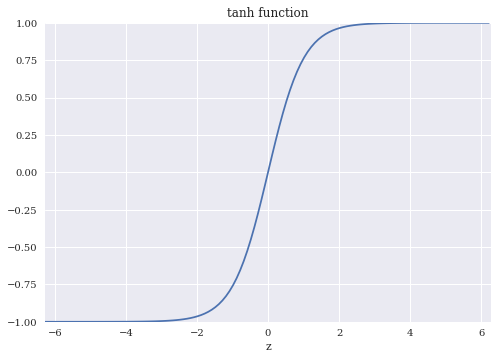

In [8]:
"""The sigmoid function (or the logistic curve) is a
function that takes any real number, z, and outputs a number (0,1).
It is useful in neural networks for assigning weights on a relative scale.
The value z is the weighted sum of parameters involved in the learning algorithm."""

import numpy
import matplotlib.pyplot as plt
import math as mt

z = numpy.arange(-5, 5, .1)
sigma_fn = numpy.vectorize(lambda z: 1/(1+numpy.exp(-z)))
sigma = sigma_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, sigma)
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('sigmoid function')

plt.show()

"""Step Function"""
z = numpy.arange(-5, 5, .02)
step_fn = numpy.vectorize(lambda z: 1.0 if z >= 0.0 else 0.0)
step = step_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, step)
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('step function')

plt.show()

"""tanh Function"""
z = numpy.arange(-2*mt.pi, 2*mt.pi, 0.1)
t = numpy.tanh(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, t)
ax.set_ylim([-1.0, 1.0])
ax.set_xlim([-2*mt.pi,2*mt.pi])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('tanh function')

plt.show()

## Two parameters

We assume now that we have two classes with $y_i$ either $0$ or $1$. Furthermore we assume also that we have only two parameters $\beta$ in our fitting of the Sigmoid function, that is we define probabilities

$$
\begin{align*}
p(y_i=1|x_i,\boldsymbol{\beta}) &= \frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}},\nonumber\\
p(y_i=0|x_i,\boldsymbol{\beta}) &= 1 - p(y_i=1|x_i,\boldsymbol{\beta}),
\end{align*}
$$

where $\boldsymbol{\beta}$ are the weights we wish to extract from data, in our case $\beta_0$ and $\beta_1$. 

Note that we used

$$
p(y_i=0\vert x_i, \boldsymbol{\beta}) = 1-p(y_i=1\vert x_i, \boldsymbol{\beta}).
$$

<!-- !split  -->
## Maximum likelihood

In order to define the total likelihood for all possible outcomes from a  
dataset $\mathcal{D}=\{(y_i,x_i)\}$, with the binary labels
$y_i\in\{0,1\}$ and where the data points are drawn independently, we use the so-called [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE) principle. 
We aim thus at maximizing 
the probability of seeing the observed data. We can then approximate the 
likelihood in terms of the product of the individual probabilities of a specific outcome $y_i$, that is

$$
\begin{align*}
P(\mathcal{D}|\boldsymbol{\beta})& = \prod_{i=1}^n \left[p(y_i=1|x_i,\boldsymbol{\beta})\right]^{y_i}\left[1-p(y_i=1|x_i,\boldsymbol{\beta}))\right]^{1-y_i}\nonumber \\
\end{align*}
$$

from which we obtain the log-likelihood and our **cost/loss** function

$$
\mathcal{C}(\boldsymbol{\beta}) = \sum_{i=1}^n \left( y_i\log{p(y_i=1|x_i,\boldsymbol{\beta})} + (1-y_i)\log\left[1-p(y_i=1|x_i,\boldsymbol{\beta}))\right]\right).
$$

## The cost function rewritten

Reordering the logarithms, we can rewrite the **cost/loss** function as

$$
\mathcal{C}(\boldsymbol{\beta}) = \sum_{i=1}^n  \left(y_i(\beta_0+\beta_1x_i) -\log{(1+\exp{(\beta_0+\beta_1x_i)})}\right).
$$

The maximum likelihood estimator is defined as the set of parameters that maximize the log-likelihood where we maximize with respect to $\beta$.
Since the cost (error) function is just the negative log-likelihood, for logistic regression we have that

$$
\mathcal{C}(\boldsymbol{\beta})=-\sum_{i=1}^n  \left(y_i(\beta_0+\beta_1x_i) -\log{(1+\exp{(\beta_0+\beta_1x_i)})}\right).
$$

This equation is known in statistics as the **cross entropy**. Finally, we note that just as in linear regression, 
in practice we often supplement the cross-entropy with additional regularization terms, usually $L_1$ and $L_2$ regularization as we did for Ridge and Lasso regression.

## Minimizing the cross entropy

The cross entropy is a convex function of the weights $\boldsymbol{\beta}$ and,
therefore, any local minimizer is a global minimizer. 


Minimizing this
cost function with respect to the two parameters $\beta_0$ and $\beta_1$ we obtain

$$
\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \beta_0} = -\sum_{i=1}^n  \left(y_i -\frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}}\right),
$$

and

$$
\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \beta_1} = -\sum_{i=1}^n  \left(y_ix_i -x_i\frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}}\right).
$$

## A more compact expression

Let us now define a vector $\boldsymbol{y}$ with $n$ elements $y_i$, an
$n\times p$ matrix $\boldsymbol{X}$ which contains the $x_i$ values and a
vector $\boldsymbol{p}$ of fitted probabilities $p(y_i\vert x_i,\boldsymbol{\beta})$. We can rewrite in a more compact form the first
derivative of cost function as

$$
\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}} = -\boldsymbol{X}^T\left(\boldsymbol{y}-\boldsymbol{p}\right).
$$

If we in addition define a diagonal matrix $\boldsymbol{W}$ with elements 
$p(y_i\vert x_i,\boldsymbol{\beta})(1-p(y_i\vert x_i,\boldsymbol{\beta})$, we can obtain a compact expression of the second derivative as

$$
\frac{\partial^2 \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}\partial \boldsymbol{\beta}^T} = \boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X}.
$$

## Extending to more predictors

Within a binary classification problem, we can easily expand our model to include multiple predictors. Our ratio between likelihoods is then with $p$ predictors

$$
\log{ \frac{p(\boldsymbol{\beta}\boldsymbol{x})}{1-p(\boldsymbol{\beta}\boldsymbol{x})}} = \beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p.
$$

Here we defined $\boldsymbol{x}=[1,x_1,x_2,\dots,x_p]$ and $\boldsymbol{\beta}=[\beta_0, \beta_1, \dots, \beta_p]$ leading to

$$
p(\boldsymbol{\beta}\boldsymbol{x})=\frac{ \exp{(\beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p)}}{1+\exp{(\beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p)}}.
$$

## Including more classes

Till now we have mainly focused on two classes, the so-called binary
system. Suppose we wish to extend to $K$ classes.  Let us for the sake
of simplicity assume we have only two predictors. We have then following model

$$
\log{\frac{p(C=1\vert x)}{p(K\vert x)}} = \beta_{10}+\beta_{11}x_1,
$$

and

$$
\log{\frac{p(C=2\vert x)}{p(K\vert x)}} = \beta_{20}+\beta_{21}x_1,
$$

and so on till the class $C=K-1$ class

$$
\log{\frac{p(C=K-1\vert x)}{p(K\vert x)}} = \beta_{(K-1)0}+\beta_{(K-1)1}x_1,
$$

and the model is specified in term of $K-1$ so-called log-odds or
**logit** transformations.


## More classes

In our discussion of neural networks we will encounter the above again
in terms of a slightly modified function, the so-called **Softmax** function.

The softmax function is used in various multiclass classification
methods, such as multinomial logistic regression (also known as
softmax regression), multiclass linear discriminant analysis, naive
Bayes classifiers, and artificial neural networks.  Specifically, in
multinomial logistic regression and linear discriminant analysis, the
input to the function is the result of $K$ distinct linear functions,
and the predicted probability for the $k$-th class given a sample
vector $\boldsymbol{x}$ and a weighting vector $\boldsymbol{\beta}$ is (with two
predictors):

$$
p(C=k\vert \mathbf {x} )=\frac{\exp{(\beta_{k0}+\beta_{k1}x_1)}}{1+\sum_{l=1}^{K-1}\exp{(\beta_{l0}+\beta_{l1}x_1)}}.
$$

It is easy to extend to more predictors. The final class is

$$
p(C=K\vert \mathbf {x} )=\frac{1}{1+\sum_{l=1}^{K-1}\exp{(\beta_{l0}+\beta_{l1}x_1)}},
$$

and they sum to one. Our earlier discussions were all specialized to
the case with two classes only. It is easy to see from the above that
what we derived earlier is compatible with these equations.

To find the optimal parameters we would typically use a gradient
descent method.  Newton's method and gradient descent methods are
discussed in the material on [optimization
methods](https://compphysics.github.io/MachineLearning/doc/pub/Splines/html/Splines-bs.html).


## Friday September 24




## Wisconsin Cancer Data

We show here how we can use a simple regression case on the breast
cancer data using Logistic regression as our algorithm for
classification.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))

## Using the correlation matrix

In addition to the above scores, we could also study the covariance (and the correlation matrix).
We use **Pandas** to compute the correlation matrix.

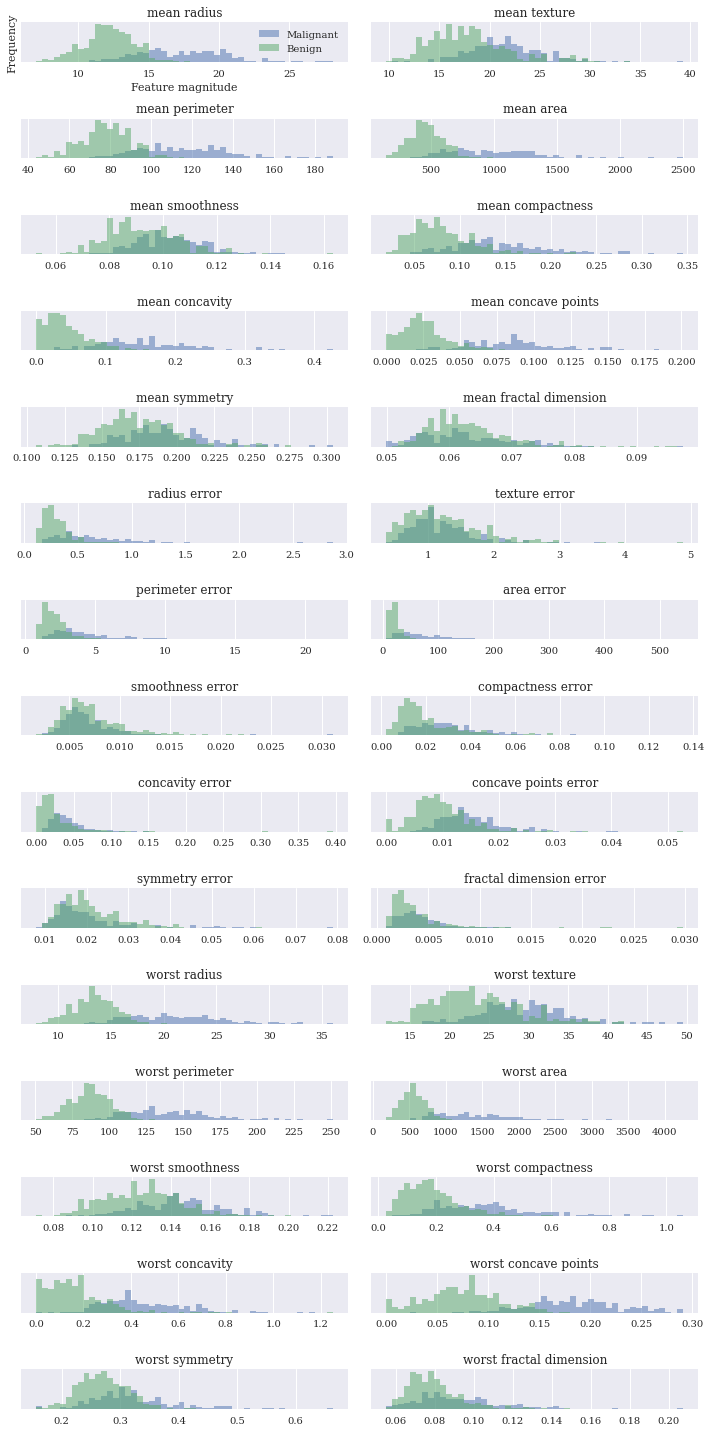

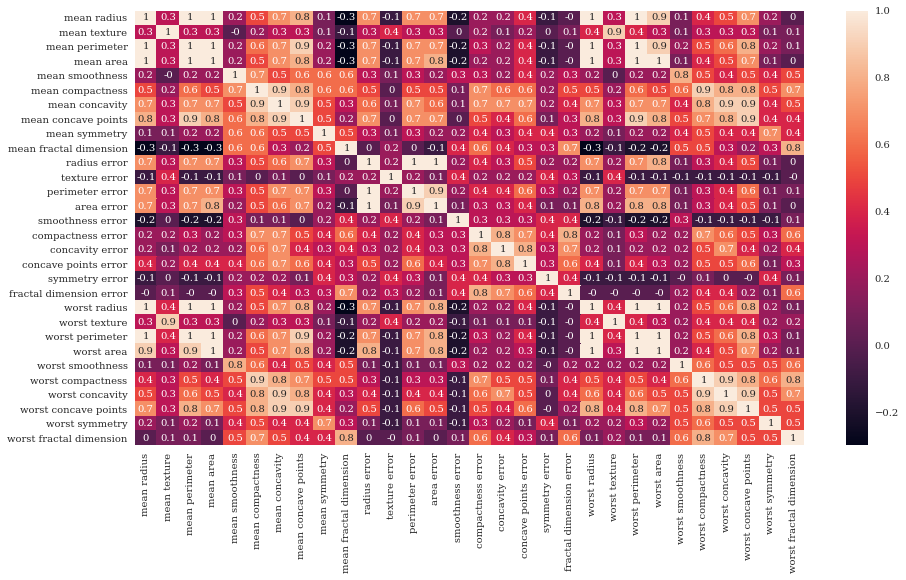

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
cancer = load_breast_cancer()
import pandas as pd
# Making a data frame
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

fig, axes = plt.subplots(15,2,figsize=(10,20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:,i], bins =50)
    ax[i].hist(malignant[:,i], bins = bins, alpha = 0.5)
    ax[i].hist(benign[:,i], bins = bins, alpha = 0.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["Malignant", "Benign"], loc ="best")
fig.tight_layout()
plt.show()

import seaborn as sns
correlation_matrix = cancerpd.corr().round(1)
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
plt.figure(figsize=(15,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

## Discussing the correlation data

In the above example we note two things. In the first plot we display
the overlap of benign and malignant tumors as functions of the various
features in the Wisconsing breast cancer data set. We see that for
some of the features we can distinguish clearly the benign and
malignant cases while for other features we cannot. This can point to
us which features may be of greater interest when we wish to classify
a benign or not benign tumour.

In the second figure we have computed the so-called correlation
matrix, which in our case with thirty features becomes a $30\times 30$
matrix.

We constructed this matrix using **pandas** via the statements

In [ ]:
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

and then

In [ ]:
correlation_matrix = cancerpd.corr().round(1)

Diagonalizing this matrix we can in turn say something about which
features are of relevance and which are not. This leads  us to
the classical Principal Component Analysis (PCA) theorem with
applications. This will be discussed later this semester ([week 43](https://compphysics.github.io/MachineLearning/doc/pub/week43/html/week43-bs.html)).



## Other measures in classification studies: Cancer Data  again

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
#Cross validation
accuracy = cross_validate(logreg,X_test_scaled,y_test,cv=10)['test_score']
print(accuracy)
print("Test set accuracy with Logistic Regression  and scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))


import scikitplot as skplt
y_pred = logreg.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()
y_probas = logreg.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()

(426, 30)
(143, 30)
Test set accuracy with Logistic Regression: 0.94
Test set accuracy Logistic Regression with scaled data: 0.96
[1.         1.         1.         1.         1.         1.
 1.         1.         0.92857143 0.92857143]
Test set accuracy with Logistic Regression  and scaled data: 0.96


/Users/mhjensen/Software/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ModuleNotFoundError: No module named 'scikitplot'

## Friday September 25




## Optimization, the central part of any Machine Learning algortithm

[Overview Video, why do we care about gradient methods?](https://www.uio.no/studier/emner/matnat/fys/FYS-STK3155/h20/forelesningsvideoer/OverarchingAimsWeek39.mp4?vrtx=view-as-webpage)



Almost every problem in machine learning and data science starts with
a dataset $X$, a model $g(\beta)$, which is a function of the
parameters $\beta$ and a cost function $C(X, g(\beta))$ that allows
us to judge how well the model $g(\beta)$ explains the observations
$X$. The model is fit by finding the values of $\beta$ that minimize
the cost function. Ideally we would be able to solve for $\beta$
analytically, however this is not possible in general and we must use
some approximative/numerical method to compute the minimum.


## Revisiting our Logistic Regression case

In our discussion on Logistic Regression we studied the 
case of
two classes, with $y_i$ either
$0$ or $1$. Furthermore we assumed also that we have only two
parameters $\beta$ in our fitting, that is we
defined probabilities

$$
\begin{align*}
p(y_i=1|x_i,\boldsymbol{\beta}) &= \frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}},\nonumber\\
p(y_i=0|x_i,\boldsymbol{\beta}) &= 1 - p(y_i=1|x_i,\boldsymbol{\beta}),
\end{align*}
$$

where $\boldsymbol{\beta}$ are the weights we wish to extract from data, in our case $\beta_0$ and $\beta_1$. 

## The equations to solve

Our compact equations used a definition of a vector $\boldsymbol{y}$ with $n$
elements $y_i$, an $n\times p$ matrix $\boldsymbol{X}$ which contains the
$x_i$ values and a vector $\boldsymbol{p}$ of fitted probabilities
$p(y_i\vert x_i,\boldsymbol{\beta})$. We rewrote in a more compact form
the first derivative of the cost function as

$$
\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}} = -\boldsymbol{X}^T\left(\boldsymbol{y}-\boldsymbol{p}\right).
$$

If we in addition define a diagonal matrix $\boldsymbol{W}$ with elements 
$p(y_i\vert x_i,\boldsymbol{\beta})(1-p(y_i\vert x_i,\boldsymbol{\beta})$, we can obtain a compact expression of the second derivative as

$$
\frac{\partial^2 \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}\partial \boldsymbol{\beta}^T} = \boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X}.
$$

This defines what is called  the Hessian matrix.

## Solving using Newton-Raphson's method

If we can set up these equations, Newton-Raphson's iterative method is normally the method of choice. It requires however that we can compute in an efficient way the  matrices that define the first and second derivatives. 

Our iterative scheme is then given by

$$
\boldsymbol{\beta}^{\mathrm{new}} = \boldsymbol{\beta}^{\mathrm{old}}-\left(\frac{\partial^2 \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}\partial \boldsymbol{\beta}^T}\right)^{-1}_{\boldsymbol{\beta}^{\mathrm{old}}}\times \left(\frac{\partial \mathcal{C}(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}}\right)_{\boldsymbol{\beta}^{\mathrm{old}}},
$$

or in matrix form as

$$
\boldsymbol{\beta}^{\mathrm{new}} = \boldsymbol{\beta}^{\mathrm{old}}-\left(\boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X} \right)^{-1}\times \left(-\boldsymbol{X}^T(\boldsymbol{y}-\boldsymbol{p}) \right)_{\boldsymbol{\beta}^{\mathrm{old}}}.
$$

The right-hand side is computed with the old values of $\beta$. 

If we can compute these matrices, in particular the Hessian, the above is often the easiest method to implement. 


## Brief reminder on Newton-Raphson's method

Let us quickly remind ourselves how we derive the above method.

Perhaps the most celebrated of all one-dimensional root-finding
routines is Newton's method, also called the Newton-Raphson
method. This method  requires the evaluation of both the
function $f$ and its derivative $f'$ at arbitrary points. 
If you can only calculate the derivative
numerically and/or your function is not of the smooth type, we
normally discourage the use of this method.

## The equations

The Newton-Raphson formula consists geometrically of extending the
tangent line at a current point until it crosses zero, then setting
the next guess to the abscissa of that zero-crossing.  The mathematics
behind this method is rather simple. Employing a Taylor expansion for
$x$ sufficiently close to the solution $s$, we have

<!-- Equation labels as ordinary links -->
<div id="eq:taylornr"></div>

$$
f(s)=0=f(x)+(s-x)f'(x)+\frac{(s-x)^2}{2}f''(x) +\dots.
    \label{eq:taylornr} \tag{14}
$$

For small enough values of the function and for well-behaved
functions, the terms beyond linear are unimportant, hence we obtain

$$
f(x)+(s-x)f'(x)\approx 0,
$$

yielding

$$
s\approx x-\frac{f(x)}{f'(x)}.
$$

Having in mind an iterative procedure, it is natural to start iterating with

$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}.
$$

## Simple geometric interpretation

The above is Newton-Raphson's method. It has a simple geometric
interpretation, namely $x_{n+1}$ is the point where the tangent from
$(x_n,f(x_n))$ crosses the $x$-axis.  Close to the solution,
Newton-Raphson converges fast to the desired result. However, if we
are far from a root, where the higher-order terms in the series are
important, the Newton-Raphson formula can give grossly inaccurate
results. For instance, the initial guess for the root might be so far
from the true root as to let the search interval include a local
maximum or minimum of the function.  If an iteration places a trial
guess near such a local extremum, so that the first derivative nearly
vanishes, then Newton-Raphson may fail totally


## Extending to more than one variable

Newton's method can be generalized to systems of several non-linear equations
and variables. Consider the case with two equations

$$
\begin{array}{cc} f_1(x_1,x_2) &=0\\
                     f_2(x_1,x_2) &=0,\end{array}
$$

which we Taylor expand to obtain

$$
\begin{array}{cc} 0=f_1(x_1+h_1,x_2+h_2)=&f_1(x_1,x_2)+h_1
                     \partial f_1/\partial x_1+h_2
                     \partial f_1/\partial x_2+\dots\\
                     0=f_2(x_1+h_1,x_2+h_2)=&f_2(x_1,x_2)+h_1
                     \partial f_2/\partial x_1+h_2
                     \partial f_2/\partial x_2+\dots
                       \end{array}.
$$

Defining the Jacobian matrix ${\bf \boldsymbol{J}}$ we have

$$
{\bf \boldsymbol{J}}=\left( \begin{array}{cc}
                         \partial f_1/\partial x_1  & \partial f_1/\partial x_2 \\
                          \partial f_2/\partial x_1     &\partial f_2/\partial x_2
             \end{array} \right),
$$

we can rephrase Newton's method as

$$
\left(\begin{array}{c} x_1^{n+1} \\ x_2^{n+1} \end{array} \right)=
\left(\begin{array}{c} x_1^{n} \\ x_2^{n} \end{array} \right)+
\left(\begin{array}{c} h_1^{n} \\ h_2^{n} \end{array} \right),
$$

where we have defined

$$
\left(\begin{array}{c} h_1^{n} \\ h_2^{n} \end{array} \right)=
   -{\bf \boldsymbol{J}}^{-1}
   \left(\begin{array}{c} f_1(x_1^{n},x_2^{n}) \\ f_2(x_1^{n},x_2^{n}) \end{array} \right).
$$

We need thus to compute the inverse of the Jacobian matrix and it
is to understand that difficulties  may
arise in case ${\bf \boldsymbol{J}}$ is nearly singular.

It is rather straightforward to extend the above scheme to systems of
more than two non-linear equations. In our case, the Jacobian matrix is given by the Hessian that represents the second derivative of cost function. 



## Steepest descent

The basic idea of gradient descent is
that a function $F(\mathbf{x})$, 
$\mathbf{x} \equiv (x_1,\cdots,x_n)$, decreases fastest if one goes from $\bf {x}$ in the
direction of the negative gradient $-\nabla F(\mathbf{x})$.

It can be shown that if

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k),
$$

with $\gamma_k > 0$.

For $\gamma_k$ small enough, then $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$. This means that for a sufficiently small $\gamma_k$
we are always moving towards smaller function values, i.e a minimum.

<!-- !split  -->
## More on Steepest descent

The previous observation is the basis of the method of steepest
descent, which is also referred to as just gradient descent (GD). One
starts with an initial guess $\mathbf{x}_0$ for a minimum of $F$ and
computes new approximations according to

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k), \ \ k \geq 0.
$$

The parameter $\gamma_k$ is often referred to as the step length or
the learning rate within the context of Machine Learning.

<!-- !split  -->
## The ideal

Ideally the sequence $\{\mathbf{x}_k \}_{k=0}$ converges to a global
minimum of the function $F$. In general we do not know if we are in a
global or local minimum. In the special case when $F$ is a convex
function, all local minima are also global minima, so in this case
gradient descent can converge to the global solution. The advantage of
this scheme is that it is conceptually simple and straightforward to
implement. However the method in this form has some severe
limitations:

In machine learing we are often faced with non-convex high dimensional
cost functions with many local minima. Since GD is deterministic we
will get stuck in a local minimum, if the method converges, unless we
have a very good intial guess. This also implies that the scheme is
sensitive to the chosen initial condition.

Note that the gradient is a function of $\mathbf{x} =
(x_1,\cdots,x_n)$ which makes it expensive to compute numerically.


<!-- !split  -->
## The sensitiveness of the gradient descent

The gradient descent method 
is sensitive to the choice of learning rate $\gamma_k$. This is due
to the fact that we are only guaranteed that $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$ for sufficiently small $\gamma_k$. The problem is to
determine an optimal learning rate. If the learning rate is chosen too
small the method will take a long time to converge and if it is too
large we can experience erratic behavior.

Many of these shortcomings can be alleviated by introducing
randomness. One such method is that of Stochastic Gradient Descent
(SGD), see below.